# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import zipfile
import math
from datetime import date, time, datetime
pd.options.mode.chained_assignment = None
# default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

**LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had. **

**This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: **

![lego-schema](lego-schema.png)

**In this task you have to apply the following Data Wrangling pipeline:**
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

**Each of these subtasks are described in detail below.**

### A1. Loading phase
**Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).**

** *Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).* **

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

First we just load each file in a dataframe

In [4]:
colors = pd.read_csv(LEGO_DATA_FOLDER + '/colors.csv.zip')
inventories = pd.read_csv(LEGO_DATA_FOLDER + '/inventories.csv.zip')
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_parts.csv.zip')
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_sets.csv.zip')
part_categories = pd.read_csv(LEGO_DATA_FOLDER + '/part_categories.csv.zip')
parts = pd.read_csv(LEGO_DATA_FOLDER + '/parts.csv.zip')
sets = pd.read_csv(LEGO_DATA_FOLDER + '/sets.csv.zip')
themes = pd.read_csv(LEGO_DATA_FOLDER + '/themes.csv.zip')

Here we load the different datasets that compose our database. As a best practice we make sure to set unique indices to all the dataframes. During the cleaning and querying we can use reset_index() if needed

In [5]:
colors = colors.set_index('id')
inventories = inventories.set_index('id')

# For this set combine inventory_id and set_id to a hierarchiacal index to make it unique
inventory_sets_hier = inventory_sets.set_index(['inventory_id', 'set_id'])

part_categories = part_categories.set_index('id')
sets = sets.set_index('id')
themes = themes.set_index('id')

We did not change the index for inventory parts since even combinig the 3 id's still did not give a unique index. Hence we leave it as such.

The method can be used to check for uniqueness of the indexes and check every different value and value format. This is useful when checking for inconsistencies. To check a particular dataframe, replace df with appropriate dataframe variable. This will be useful for the cleaning phase.

In [6]:
def index_uniqueness(df):

    print('Is the index unique? ', df.index.is_unique, '\n')
    print('The index values are:')
    print(df.index.unique().tolist())
    print('\nDo the columns have unique values?')
    for c in df.columns:
        printer = c.ljust(25) + str(df[c].is_unique)
        print(printer)

    print('\nThe values of the columns are:')
    for c in df.columns:
        print(c, '      ', df[c].unique())
        
index_uniqueness(sets)

Is the index unique?  True 

The index values are:
['00-1', '0011-2', '0011-3', '0012-1', '0013-1', '0014-1', '0015-1', '0016-1', '00-2', '00-3', '00-4', '005-1', '00-6', '00-7', '010-1', '010-3', '011-1', '022-1', '03093-1', '033-2', '044-1', '055-2', '066-1', '080-1', '088-1', '10000-1', '10001-1', '10002-1', '10003-1', '10004-1', '10005-1', '10006-1', '10007-1', '10008-1', '10009-1', '100-1', '10010-1', '10011-1', '10012-1', '10013-1', '10014-1', '10015-1', '10016-1', '10017-1', '10018-1', '10019-1', '100-2', '10020-1', '10020-2', '10021-1', '10022-1', '10023-1', '10024-1', '10025-1', '10026-1', '10027-1', '10029-1', '10030-1', '10036-1', '10037-1', '10039-1', '10040-1', '10041-1', '10042-1', '10043-1', '10044-1', '10045-1', '10046-1', '10047-1', '10048-1', '10049-1', '10050-1', '10051-1', '10053-1', '10054-1', '10055-1', '10056-1', '10057-1', '10058-1', '10059-1', '10060-1', '10061-1', '10062-1', '10063-1', '10064-1', '10065-1', '10066-1', '10067-1', '10068-1', '10069-1', '10070-1'

### A2. Cleaning phase
**Explore the following columns from your dataset:**

1. sets: year
* inventory_parts: quantity

**What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset.**

First. We define this method to inspect each dataframe for inconsistencies to aid us spot 'bad stuff' during the cleaning

In [7]:
def quick_report(df):

    print("Types:\n")
    print(df.dtypes, '\n')
    print('Is the index unique: ', df.index.is_unique, '\n')
    print('The index values are:\n')
    print(df.index.unique().tolist(), '\n')
    print('Do the columns have unique values?')
    for c in df.columns:
        printer = c.ljust(25) + str(df[c].is_unique)
        print(printer)

    print('\n', 'What are these values:')
    for c in df.columns:
        print(c, '      ', df[c].unique())

    print('\n', 'First few entries:', '\n', df.head(10))
    print('\n', 'Last few entries:', '\n', df.tail(10))

quick_report(themes)

Types:

name          object
parent_id    float64
dtype: object 

Is the index unique:  True 

The index values are:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,

We start cleaning the sets dataframe. We can see a few inconsistencies in the year field. We noticed the following:

- some negative values. In that case we just eliminate the minus
- 5 digit numbers. We deal with those by taking the first 4 digits of the number and ignoring the fifth
- some years are expressed as 70s, 80s, etc. We decided to replace those with the first year of the decade, so 1970, etc

We perform the appropiate substitutions and convert the column to a datetime object for future ease of manipulation.

In [8]:
# change negative values to positive. Here the '-' are assumed to be typos and hence not dropped
sets.year = sets['year'].apply(lambda x: x[1:] if x[0] == '-' else x)

# make sure every year is a 4 digit number
sets.year = sets['year'].apply(lambda x: x[:4])

# remove 70s, 80s, ... and replace with 1970, 1980,...
sets.year = sets['year'].apply(lambda x: '19' + x[:-1] if 's' in x else x)

# convert year (string) to datetime objects
sets.year = sets['year'].apply(lambda x: datetime.strptime(x,'%Y'))

sets.head(5)

,name,year,theme_id,num_parts
id,,,,
00-1,Weetabix Castle,1970-01-01,414,471
0011-2,Town Mini-Figures,1978-01-01,84,12
0011-3,Castle 2 for 1 Bonus Offer,1987-01-01,199,2
0012-1,Space Mini-Figures,1979-01-01,143,12
0013-1,Space Mini-Figures,1979-01-01,143,12


We are not done with sets. We notice that there are sets in this dataframe that contain 0 or -1 (?) parts. Upon further inspection we realized those are not actual lego sets but things like 'Star wars poster' or 'The LEGO Ideas Book'. Those are not useful for our purposes, we just delete them.

As a sidenote, after this purge there are still sets that are not actual LEGO sets in this dataframe, we just can't decide on a threshold on the number of parts for what we could call a proper LEGO set. For example, in the query for the dominant color.

In [9]:
# retain only sets with 2 or more parts
sets = sets[sets["num_parts"] > 1]

Next is the inventory dataframe. Here we only do two changes

- replace the -np.inf values with 0
- change the quantities column to integer type. This is mostly for visual clarity and to avoid future mistakes

In [10]:
# replace -np.inf with 0
inventory_parts = inventory_parts.replace(-np.inf, 0)

# change quantities to integers
inventory_parts.quantity = inventory_parts.quantity.apply(lambda x: int(x))

inventory_parts.head(5)

,inventory_id,part_id,color_id,quantity,is_spare
0,1,48379c01,72,1,f
1,1,48395,7,1,f
2,1,mcsport6,25,1,f
3,1,paddle,0,1,f
4,3,11816pr0005,78,1,f


Next up is the colors dataframe. One simple change here

- the 'unknown color' with id -1 gives us no information so we remove it

As a note, we decided to leave the 'no color' value with id 9999 as is. This way if someone wanted to add more colors they have indices 1008 - 9998 free.

In [11]:
# remove 'unknown' color with id = -1
colors = colors[1:]

Finally, the themes dataframe has som NaN values in the parent column (no parent). Since we don't like NaNs we set them to 0 and from now on we work under the assumption that having a parent_id of 0 means no parent.

In [12]:
# replace NaNs with 0
themes = themes.replace(np.nan, 0)

The rest of the datasets are fairly clean so we leave them as is.

### A3. Querying phase
**Answer the following queries using the functionality of `Pandas`:**

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. Do you see a trend over the last years? How do you interpret it?

**The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:**

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

#### Query 1
In order to distinguish which sets contain cars without going overboard (no semantics or external filters) we just choose set names that either:

- Contain 'Car ' or 'Cars '. since those are capitalized we assume they are going to be the start of a word, we don't need to put a space before. But we do need the space after to avoid words that just start with 'Car' or 'Cars' like 'Carbonized' or 'Carse'
- Contain ' car ' or ' cars '. That is 'car' or 'cars' as separate words in the title
- Contain words that end with 'car' or 'cars'. This might seem counterintuitive, but a quick search on a web dictionary https://www.thefreedictionary.com/words-that-end-in-car shows us that the few words that end with car that are not actual cars are either very obscure like 'vicar' or very domain specific like 'trocar'. That means it is extremely unlikely that a bad word other than a proper name like 'Oscar' (again unlikely in a product name) will mess this filter. This is important beause we don't want to miss specific types of car like 'supercar' or 'motorcar'

Then we put this data into a dataframe, merge it with inventory_sets to get the inventory_id's and label them properly.

In [13]:
# select the set_ids for whom the name contains ' Cars ', ' cars ', ' Car ', ' car ' 
sets_car_cond = (sets.name.str.contains('Car ') | sets.name.str.contains('Cars ') | sets.name.str.contains(' car ') | sets.name.str.contains(' cars ') | sets.name.str.endswith('car') | sets.name.str.endswith('cars'))
sets_car = sets[sets_car_cond]

# merge this dataframe with inventory_sets, which will contain the inventory_id's
# without any parameter, it will do an inner join (intersection between the 2 sets)
sets_inventories_cars = pd.merge(sets_car,inventory_sets,left_index=True,right_on='set_id')[['set_id','name']]
sets_inventories_cars

# make the dataframe look cleaner with correct labels
sets_inventories_cars = sets_inventories_cars.reset_index()
sets_inventories_cars.columns = ['inventory_id','set_id','set_name']

# print the resulting inventory_id's
sets_inventories_cars = sorted(sets_inventories_cars['inventory_id'].unique())
print('Here is the list of inventories:')
print(sets_inventories_cars)

Here is the list of inventories:
[103, 170, 294, 445, 498, 1064, 1142, 1205, 1410, 1479, 1500, 1584, 1585, 1586, 1847, 1882, 1883, 2198, 2232, 2285, 2287, 2317, 2318]


#### Query 2
We use pylab (imported at the beginning as pl) for the barchart

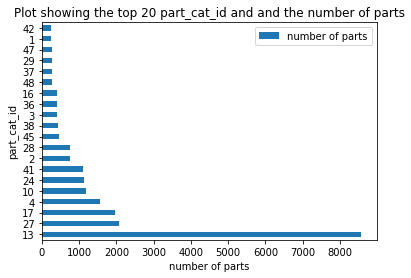

In [14]:
res = parts.groupby(['part_cat_id'])['id'].count().sort_values(ascending=False).iloc[:20]
new_res = res.to_frame('number of parts')
new_res.plot(kind = 'barh',title='Plot showing the top 20 part_cat_id and and the number of parts')


pl.xlabel('number of parts');

### Query 3

This querry can be divided into two querries:
- 1) Find the most dominant color per sets
- 2) For each dominant colors plot the number of sets

Part 1

The technic here is to merge different data frames in order to obtain a dataframe with labels: set_id, inventory_id, color_id, quantity and color_name. Hence we will need to merge the following dataframes: sets, inventory_sets, inventory_parts and colors. We shall do it in the following order:
- 1) Merge sets with inventory_sets with set_id as the common label
- 2) Then merge the above resulting dataframe with inventory parts with inventory_id as the common label
- 3) Finally merge the above resulting dataframe with colors with color_id as the common label 

Afterwards you need to take the resulting dataframe and group by set_id and color name to obtain the quantity for each colors of each sets. Then from the dataframe we can sort the values according to quantity (ascending = False) and just select the top color which will be the most dominant color for that particular set.

In [105]:
# The first merge.
inventory_sets_parts = pd.merge(sets,inventory_sets,left_index=True,right_on='set_id')[['set_id','inventory_id']]

# The second merge
inventory_sets_parts_color = pd.merge(inventory_sets_parts,inventory_parts)

# Take appropriate columns (not all of them are useful).
inventory_sets_parts_color = inventory_sets_parts_color[['set_id','color_id','quantity']]

# Final merge.
inventory_sets_parts_color_name = pd.merge(inventory_sets_parts_color, colors,right_index=True,left_on='color_id')[['set_id','name','quantity']]

# Group by and sum in order to obtain the total quantities per colors per set.
inventory_sets_parts_color_name = inventory_sets_parts_color_name.groupby(['set_id','name']).sum()

# Sort the dataframe in order of decreasing quantities
inventory_sets_parts_color_name = inventory_sets_parts_color_name.reset_index().sort_values(['set_id','quantity'], ascending = [True,False]).set_index(['set_id'])

dominant_color = pd.DataFrame(columns=['set_id','color','quantity'])

# For loop necessary since while iterating over each indexes of set_id (hierachical indexes), some sets have only 1 color
# Which will be a single value and some sets will have multiple colors, which will be Series. So we created a new dataframe
# and 
for i in inventory_sets_parts_color_name.index.unique():
    the_colors_quantity = inventory_sets_parts_color_name.loc[i].quantity
    the_colors_name = inventory_sets_parts_color_name.loc[i]
    if isinstance(the_colors_quantity,pd.Series):
        df_to_append = pd.DataFrame(data = [[i,the_colors_name.name.iloc[0],the_colors_quantity.iloc[0]]],columns=['set_id','color','quantity'])
        dominant_color = pd.concat([dominant_color,df_to_append])
    else:
        df_to_append = pd.DataFrame(data = [[i,the_colors_name[0],the_colors_quantity]],columns=['set_id','color','quantity'])
        dominant_color = pd.concat([dominant_color,df_to_append])


    
dominant_color_per_set_id = dominant_color.set_index('set_id')

# Remove sets with dominant color quantity = 0, which means that the set has no dominant color.
dominant_color_per_set_id = dominant_color_per_set_id.drop(dominant_color_per_set_id[dominant_color_per_set_id.quantity == 0.0].index)

# Sort by quantities
dominant_color_per_set_id = dominant_color_per_set_id.sort_values(by='quantity',ascending = False)

dominant_color_per_set_id


,color,quantity
set_id,,
1062-1,White,62
4548-1,Dark Bluish Gray,16
10173-1,Dark Bluish Gray,16
9750-1,[No Color],9
9700-1,[No Color],9
8905-1,Black,3
3305-1,[No Color],3
347-1,Green,3
346-2,Green,3


Part 2

For this querry, a lot of the work is already done in the previous part. So we can first get the list of dominant colors. Then the following merges:
- 1) Merge with the dataframe from part 1 above
- 2) From the merged dataframe, group by the color name and sum to obtain the number of sets per dominant colors
- 3) Merge the above resulting dataset with colors in order to obtain the rgb value for each color.
- 4) Plot the graph.

,hex,number of sets
color name,,
Royal Blue,#4C61DB,44
Black,#05131D,41
[No Color],#05131D,34
Green,#237841,7
Flat Dark Gold,#B48455,6
Dark Bluish Gray,#6C6E68,4
Red,#C91A09,4
White,#FFFFFF,4
Light Bluish Gray,#A0A5A9,1


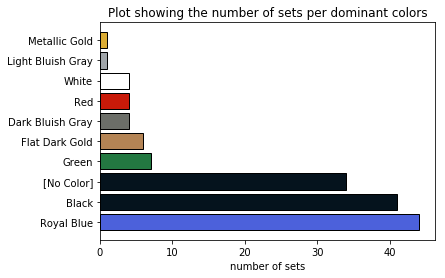

In [106]:
# necessary for x axis label
import pylab as pl

# Get the list of dominant colors (no duplicates) and convert to dataframe
all_dominant_colors = dominant_color_per_set_id['color'].unique()
all_dominant_colors = pd.DataFrame(all_dominant_colors,columns=['color name'])

# First merge with group by and sum
sets_per_colors = pd.merge(all_dominant_colors,inventory_sets_parts_color_name.reset_index(),left_on='color name',right_on='name')[['color name','set_id']].groupby('color name').count()

# Rename column for consistency
sets_per_colors.columns = ['number of sets']

# Sort by decreasing number of sets
sets_per_colors = sets_per_colors.sort_values(by='number of sets', ascending = False)
sets_per_colors

# Get the rgb value for each color, will be necessary for plot (In fact rgb code is hex code)
sets_per_colors_rgb = pd.merge(sets_per_colors,colors,left_index=True, right_on='name')[['name','rgb','number of sets']]
sets_per_colors_rgb.columns = ['color name', 'hex', 'number of sets']
sets_per_colors_rgb = sets_per_colors_rgb.set_index('color name')

# Give the rgb (hex format) the correct format
sets_per_colors_rgb.hex = sets_per_colors_rgb.hex.apply(lambda x: '#'+x)

# Plot graph
plt.barh(sets_per_colors_rgb.index, sets_per_colors_rgb['number of sets'], color = sets_per_colors_rgb.hex.tolist(), edgecolor = 'black')
pl.title('Plot showing the number of sets per dominant colors')
pl.xlabel('number of sets')

sets_per_colors_rgb

### Query 4

For this querry we re used the previous dataframe (most dominant colors per set, which is the color we used for each set to calculate the luminance) and just added the hex colors and years from colors and sets respectively. We then converted the hex color codes to rgb using the webcolors library (To install it: pip install webcolors==1.3) and then to the luinance using the formula. To plot the years, we converted the years back to integers only taking the year.

In [107]:
#To conver hex to rgb
import webcolors

# First merge with colors to get the hex format (rgb label)
df = pd.merge(dominant_color_per_set_id.reset_index(), colors, left_on='color', right_on='name')[['set_id','color','rgb']]

# Second merge to get the publishing years
df = pd.merge(df,sets,left_on='set_id', right_index=True)[['set_id','color','rgb','year']]

# Convert hex formated colors to luminances via rgb format
df.rgb = df.rgb.apply(lambda x: webcolors.hex_to_rgb('#'+x))
df.rgb = df.rgb.apply(lambda x: np.sqrt(0.299*(x[0]^2) + 0.587*(x[1]^2) + 0.114*(x[2]^2)))

# Rename columns for consistency.
df.columns = ['set_id','color','luminance','year']

df = df[['luminance','year']]
df = df.drop_duplicates()

# Convert datetime years to int for plot.
df.year = df.year.apply(lambda x: int(x.year))

# Plot 
df.plot(kind='scatter',x='year',y='luminance', title = 'Luminance of sets vs their publishing year.')

ModuleNotFoundError: No module named 'webcolors'

We can clearly see that as the years progress, luminance makes jumps. Over the last years, luminance was very low then very high.

## Task B. Drop the bike

** *Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).**

**In this task you will again perform data wrangling and interpretation.**

### B1. Loading phase
**Load the json file into a `DataFrame`.**

In [82]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [83]:
bikes = pd.read_json(BIKES_DATA_FOLDER + "/metro-bike-share-trip-data.json.zip")
bikes.head(2)

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281.0,180,2016-07-07T04:20:00,3014.0,34.05661,-118.23721,Monthly Pass,30.0,2016-07-07T04:17:00,3014.0,34.05661,-118.23721,1912818,Round Trip
1,6281.0,1980,2016-07-07T06:33:00,3014.0,34.05661,-118.23721,Monthly Pass,30.0,2016-07-07T06:00:00,3014.0,34.05661,-118.23721,1919661,Round Trip


### B2. Cleaning phase
**Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.**

First we set the Trip ID field as index and check succesfully wether it is unique

In [84]:
bikes.set_index("Trip ID")
bikes.index.is_unique

True

Data types:

In [85]:
bikes.dtypes

Bike ID                       float64
Duration                        int64
End Time                       object
Ending Station ID             float64
Ending Station Latitude       float64
Ending Station Longitude      float64
Passholder Type                object
Plan Duration                 float64
Start Time                     object
Starting Station ID           float64
Starting Station Latitude     float64
Starting Station Longitude    float64
Trip ID                         int64
Trip Route Category            object
dtype: object

Aside from "Start Time" and "End Time", which we will deal with next, we find two explicitly categorical columns of data: "Passholder Type" and "Trip Route Category". We turn them into categories.

In [86]:
print(pd.Categorical(bikes["Trip Route Category"]))
print(pd.Categorical(bikes["Passholder Type"]))
bikes["Trip Route Category"] = pd.Categorical(bikes["Trip Route Category"])
bikes["Passholder Type"]     = pd.Categorical(bikes["Passholder Type"])
bikes.dtypes

[Round Trip, Round Trip, Round Trip, Round Trip, Round Trip, ..., One Way, One Way, One Way, One Way, One Way]
Length: 132427
Categories (2, object): [One Way, Round Trip]
[Monthly Pass, Monthly Pass, Flex Pass, Flex Pass, Walk-up, ..., Walk-up, Walk-up, Walk-up, Walk-up, Walk-up]
Length: 132427
Categories (4, object): [Flex Pass, Monthly Pass, Staff Annual, Walk-up]


Bike ID                        float64
Duration                         int64
End Time                        object
Ending Station ID              float64
Ending Station Latitude        float64
Ending Station Longitude       float64
Passholder Type               category
Plan Duration                  float64
Start Time                      object
Starting Station ID            float64
Starting Station Latitude      float64
Starting Station Longitude     float64
Trip ID                          int64
Trip Route Category           category
dtype: object

We transform "End Time" and "Start Time" to datetime objects.

We also notice that some values in the "Duration" column are unexpectedly large. Since this value is entirely dependent on the "Start Time" and "End Time" columns we recompute entirely to anticipate errors.

In [87]:
# transform to datetime object
bikes["End Time"]   = bikes["End Time"].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
bikes["Start Time"] = bikes["Start Time"].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

# compute the difference between end time and start time and transform to seconds
bikes["Duration"]   = pd.to_datetime(bikes["End Time"]) - pd.to_datetime(bikes["Start Time"])
bikes["Duration"]   = bikes["Duration"].apply(lambda x: x.total_seconds())

# convert to hours
bikes["Duration"] = bikes["Duration"]/3600.0
bikes.head(2)

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281.0,0.05,2016-07-07 04:20:00,3014.0,34.05661,-118.23721,Monthly Pass,30.0,2016-07-07 04:17:00,3014.0,34.05661,-118.23721,1912818,Round Trip
1,6281.0,0.55,2016-07-07 06:33:00,3014.0,34.05661,-118.23721,Monthly Pass,30.0,2016-07-07 06:00:00,3014.0,34.05661,-118.23721,1919661,Round Trip


We notice the following redundancies in our dataframe:

- Duration could be redundant because we can get it from Start and End time data. We will be using this column though, so we leave it there.
- With "Trip Route Category" we have a similar problem. Its value is "Round Trip" if Starting and Ending stations are the same and "One Way" otherwise, but since during the query phase we are going to be using this values we will leave this column as is for now.
- The latitude and longitude of the stations is completely tied to the Station ID. We are not using this values so we create a sparate dataframe with Station ID -combined for Starting and Ending- as the (unique) index and "Station Latitude" and "Station longitude" as columns, then drop the latitude and longitude from the original table. Now we have a lookup table for the coordinates of each station and our original dataframe is more readable.
- The same applies to "Plan Duration" being hardly tied to "Passholder Type". We also create a separate, smaller dataframe as a lookup table and leave "Passholder Type" only in the original frame, since we are going to be using this label.

In [88]:
# starting stations
df_starting_stations         = bikes[["Starting Station ID", "Starting Station Latitude", "Starting Station Longitude"]]
df_starting_stations.columns = ["Station ID", "Station Latitude", "Station Longitude"]

# ending stations
df_ending_stations           = bikes[["Ending Station ID", "Ending Station Latitude", "Ending Station Longitude"]]
df_ending_stations.columns   = ["Station ID", "Station Latitude", "Station Longitude"]

# combine both and drop duplicates
stations = pd.concat([df_starting_stations, df_ending_stations], axis=0)
stations.drop_duplicates(["Station ID"], inplace=True)

# index by Station ID
stations.set_index("Station ID")

# delete rows with all NaN values, this is a lookup table
stations.dropna(how="all")

stations.head(2)

,Station ID,Station Latitude,Station Longitude
0,3014.0,34.056610,-118.23721
2,3016.0,34.052898,-118.24156


In [89]:
plan_durations = pd.DataFrame([{'Passholder Type':"Flex Pass", "Plan Duration":365}, 
                               {'Passholder Type':"Monthly Pass", "Plan Duration":30}, 
                               {'Passholder Type':"Staff Pass", "Plan Duration":365}, 
                               {'Passholder Type':"Walk-up", "Plan Duration":0}])
plan_durations.head()

,Passholder Type,Plan Duration
0,Flex Pass,365
1,Monthly Pass,30
2,Staff Pass,365
3,Walk-up,0


In [90]:
bikes = bikes[["Bike ID", "Duration", "End Time", "Ending Station ID",
               "Passholder Type", "Start Time", "Starting Station ID",
               "Trip ID", "Trip Route Category"]]
bikes.head(2)

,Bike ID,Duration,End Time,Ending Station ID,Passholder Type,Start Time,Starting Station ID,Trip ID,Trip Route Category
0,6281.0,0.05,2016-07-07 04:20:00,3014.0,Monthly Pass,2016-07-07 04:17:00,3014.0,1912818,Round Trip
1,6281.0,0.55,2016-07-07 06:33:00,3014.0,Monthly Pass,2016-07-07 06:00:00,3014.0,1919661,Round Trip


The original format seems to be more susceptible to inconsistencies that what we just created. If someone changes a value in a row, they need to be very mindful that other values might be dependent on it and change the rest accordingly. 

Ideally we would drop "Duration" and "Trip Route Category" and calculate on the go, otherwise inconsistencies in the table might lead to confusion down the line.

Range of the "Start Time" and "End Time" columns

In [91]:
print("Min Start Time", bikes.sort_values("Start Time")["Start Time"].iloc[0])
print("Max Start Time", bikes.sort_values("Start Time")["Start Time"].iloc[-1])
print("Min End Time", bikes.sort_values("Start Time")["End Time"].iloc[0])
print("Max End Time", bikes.sort_values("Start Time")["End Time"].iloc[-1])

Min Start Time 2016-07-07 04:17:00
Max Start Time 2017-03-31 23:45:00
Min End Time 2016-07-07 04:20:00
Max End Time 2017-04-01 00:06:00


Value range of the rest of noncategorical data

In [92]:
bikes.describe().loc[["min","max"]]
stations.describe().loc[["min","max"]]

,Station ID,Station Latitude,Station Longitude
min,3000.0,0.000000,-118.472832
max,4108.0,34.064281,0.000000


Here we show the final types and sizes of the dataframes we will be working with

In [93]:
print("Clean bikes frame types:\n", bikes.dtypes)
print("\nShape:",bikes.shape[0])

print('\n', 'plan_durations\n', plan_durations.dtypes)
print("\nShape:",plan_durations.shape[0])

print("\ndf_station data frame\n", stations.dtypes)
print("\nShape:",stations.shape[0])

Clean bikes frame types:
 Bike ID                       float64
Duration                      float64
End Time               datetime64[ns]
Ending Station ID             float64
Passholder Type              category
Start Time             datetime64[ns]
Starting Station ID           float64
Trip ID                         int64
Trip Route Category          category
dtype: object

Shape: 132427

 plan_durations
 Passholder Type    object
Plan Duration       int64
dtype: object

Shape: 4

df_station data frame
 Station ID           float64
Station Latitude     float64
Station Longitude    float64
dtype: object

Shape: 68


### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

**1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations**

Text(0.5,0.98,'Sample Title')

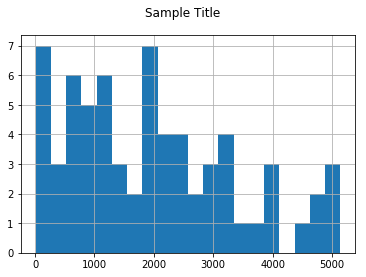

In [94]:
h = bikes["Starting Station ID"].value_counts().hist(bins=20)
pl.suptitle("Sample Title")

**2.- Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.**

We observe the presence of clear extreme outliers, even after recalculating the duration from the original times. This could be due to errors in the registration of the timestamp -that or in LA one can (and will) grab a bike for an entire week (?)

In [95]:
print(bikes.Duration.describe())

count    132427.000000
mean          0.469812
std           2.402037
min           0.016667
25%           0.100000
50%           0.166667
75%           0.300000
max         136.466667
Name: Duration, dtype: float64


The main observation is that an overwhelming majority of trips last less than one hour. Since in the full histogram it is quite to appreciate we also made one only with trips under 4 hours.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256E916DD30>]],
      dtype=object)

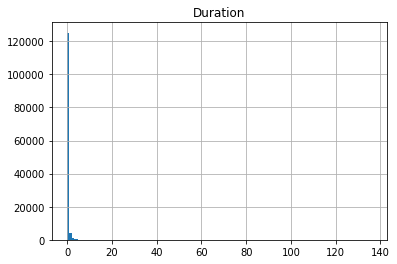

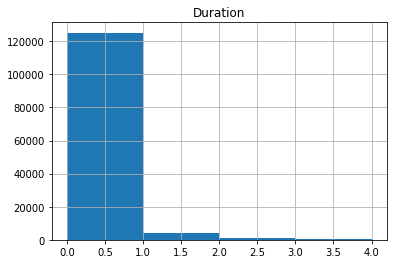

In [97]:
pd.DataFrame.hist(bikes,column="Duration", bins=range(0,137))
pd.DataFrame.hist(bikes,column="Duration", bins=range(0,5))

For the second plot we first discretize the data on starting times.

Firstly, we notice that the time interval from 7 to 20 has clearly more departues. This seems is clearly due to daytime.

Secondly, we observe the maximal activity at around 17. One reasonable explanation seems that a lot of people finish their workday at this time, but we cannot make such inference with much confidence anyways.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256E50138D0>]],
      dtype=object)

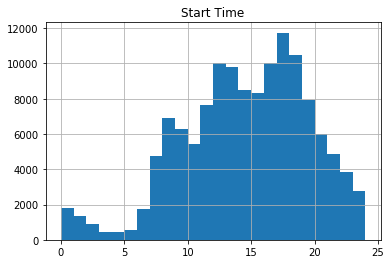

In [98]:
# discretize the values
tmp = bikes["Start Time"].apply(lambda x: x.hour)

pd.DataFrame.hist(tmp.to_frame(),column="Start Time", bins=range(0,25))

**3.- For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.**

Cold hard calculations:

In [99]:
tmp = bikes[bikes["Trip Route Category"]=="One Way"]

total_One_Way_trips = len(tmp)
staff_trips         = len(tmp[tmp["Passholder Type"]=="Staff Annual"])
monthly_pass_trips  = len(tmp[tmp["Passholder Type"]=="Monthly Pass"])
flex_pass_trips     = len(tmp[tmp["Passholder Type"]=="Flex Pass"])
walk_up_trips       = len(tmp[tmp["Passholder Type"]=="Walk-up"])

prop_staff   = staff_trips / total_One_Way_trips
prop_monthly = monthly_pass_trips / total_One_Way_trips
prop_flex    = flex_pass_trips / total_One_Way_trips
prop_walk_up = walk_up_trips / total_One_Way_trips

print("For \"One Way\" category:")
print("Prop. of \"Staff Annual\" =",prop_staff)
print("Prop. of \"Monthly pass\" =", prop_monthly)
print("Prop. of \"Flex Pass\" =",prop_flex)
print("Prop. \"Walk-up\" =",prop_walk_up)
# must add up to 1
print("Sum = ",prop_staff + prop_monthly + prop_flex + prop_walk_up)

For "One Way" category:
Prop. of "Staff Annual" = 0.0024991223817722873
Prop. of "Monthly pass" = 0.6480332993430401
Prop. of "Flex Pass" = 0.07550860065863159
Prop. "Walk-up" = 0.2739589776165561
Sum =  1.0


In [100]:
tmp = (bikes[bikes["Trip Route Category"]=="Round Trip"])

total_Round_Trip_trips = len(tmp)
staff_trips            = len(tmp[tmp["Passholder Type"]=="Staff Annual"])
monthly_pass_trips     = len(tmp[tmp["Passholder Type"]=="Monthly Pass"])
flex_pass_trips        = len(tmp[tmp["Passholder Type"]=="Flex Pass"])
walk_up_trips          = len(tmp[tmp["Passholder Type"]=="Walk-up"])

prop_staff2   = staff_trips / total_Round_Trip_trips
prop_monthly2 = monthly_pass_trips / total_Round_Trip_trips
prop_flex2    = flex_pass_trips / total_Round_Trip_trips
prop_walk_up2 = walk_up_trips / total_Round_Trip_trips

print("For \"Round Trip\" category:")
print("Prop. of \"Staff Annual\" =",prop_staff2)
print("Prop. of \"Monthly pass\" =", prop_monthly2)
print("Prop. of \"Flex Pass\" =",prop_flex2)
print("Prop. \"Walk-up\" =",prop_walk_up2)
#must add up to 1
print("Sum = ",prop_staff2 + prop_monthly2 + prop_flex2 + prop_walk_up2)

For "Round Trip" category:
Prop. of "Staff Annual" = 0.0064919827923347675
Prop. of "Monthly pass" = 0.29503324208056314
Prop. of "Flex Pass" = 0.03777864685177943
Prop. "Walk-up" = 0.6606961282753226
Sum =  1.0


Stacked bar chart

Text(0,0.5,'Proportion')

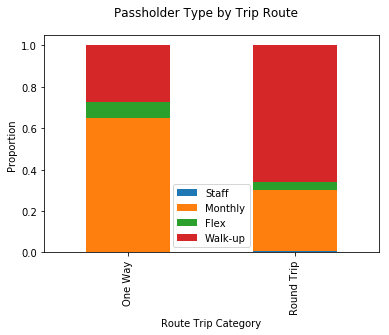

In [101]:
my_data = np.array([[prop_staff ,  prop_monthly,  prop_flex, prop_walk_up],
                    [prop_staff2,  prop_monthly2,  prop_flex2, prop_walk_up2]])

pd.DataFrame(my_data, index=["One Way","Round Trip"]).plot(kind='bar', stacked=True)
pl.suptitle("Passholder Type by Trip Route")
pl.legend(["Staff", "Monthly", "Flex", "Walk-up"])
pl.xlabel("Route Trip Category")
pl.ylabel("Proportion")

**4.- Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.**

In [102]:
# we consider hours from 5 to 12 (the morning hours).
df_tmp = bikes[bikes["Start Time"].apply(lambda x: x.hour < 12 and x.hour>5)]
df_tmp

,Bike ID,Duration,End Time,Ending Station ID,Passholder Type,Start Time,Starting Station ID,Trip ID,Trip Route Category
1,6281.0,0.550000,2016-07-07 06:33:00,3014.0,Monthly Pass,2016-07-07 06:00:00,3014.0,1919661,Round Trip
2,5861.0,0.083333,2016-07-07 10:37:00,3016.0,Flex Pass,2016-07-07 10:32:00,3016.0,1933383,Round Trip
3,5861.0,3.016667,2016-07-07 13:38:00,3016.0,Flex Pass,2016-07-07 10:37:00,3016.0,1944197,Round Trip
199,5916.0,0.133333,2016-07-08 07:01:00,3030.0,Monthly Pass,2016-07-08 06:53:00,3049.0,2015755,One Way
200,5755.0,0.133333,2016-07-08 07:28:00,3021.0,Flex Pass,2016-07-08 07:20:00,3021.0,2015754,Round Trip
201,6141.0,0.233333,2016-07-08 07:50:00,3075.0,Monthly Pass,2016-07-08 07:36:00,3022.0,2015753,One Way
202,6031.0,0.033333,2016-07-08 07:45:00,3056.0,Monthly Pass,2016-07-08 07:43:00,3034.0,2015752,One Way
203,6440.0,0.150000,2016-07-08 08:06:00,3052.0,Monthly Pass,2016-07-08 07:57:00,3049.0,2019548,One Way
204,6267.0,0.133333,2016-07-08 08:05:00,3063.0,Flex Pass,2016-07-08 07:57:00,3018.0,2019547,One Way
205,6141.0,2.966667,2016-07-08 11:03:00,3035.0,Flex Pass,2016-07-08 08:05:00,3075.0,2031376,One Way


In [ ]:
total_trips = len(df_tmp)
prop_staff = 100*len(df_tmp[df_tmp["Passholder Type"]=="Staff Annual"])/total_trips
prop_monthly = 100*len(df_tmp[df_tmp["Passholder Type"]=="Monthly Pass"])/total_trips
prop_flex = 100*len(df_tmp[df_tmp["Passholder Type"]=="Flex Pass"])/total_trips
prop_walk_up= 100*len(df_tmp[df_tmp["Passholder Type"]=="Walk-up"])/total_trips

prop_one_way=100*len(df_tmp[df_tmp["Trip Route Category"]=="One Way"])/total_trips
prop_round_trip=100*len(df_tmp[df_tmp["Trip Route Category"]=="Round Trip"])/total_trips

my_data = np.array([[prop_staff ,  prop_monthly,  prop_flex, prop_walk_up], [prop_one_way,  prop_round_trip,0,0]])
pd.DataFrame(my_data, index=["Passholder Type", "Trip route category"]).plot(kind='bar', stacked=True)

We observe in the **first chart** that during these hours the majority of the travellers have a "Monthly Pass"(orange portion) and also that there are so few travellers with the "Staff Annual"(blue portion). <br>In the **second chart** we see that the overwhelming majority of the travellers do a "One Way" trip.

**5.- Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.**

Firstly, we have to find the two hours intervals that have(approximately) the same number of departures.
For doing that, we create a temporal data frame and change the "Start Time" column for getting just the hours data. Then, we sort the data frame by the "Start Time" and finally we divide the data frame in two parts. 

We see that the last trip have the "Starting Time" 14, so we decide to take the intervals: Period1 = [0,14] and Period2 = [15,23]

In [104]:
df_tmp=bikes.copy()
df_tmp["Start Time"]=df_tmp["Start Time"].apply(lambda x: x.hour)

df_tmp.sort_values(ascending=True, by="Start Time", inplace=True)
df_tmp[:math.floor(len(df_tmp)/2)]

,Bike ID,Duration,End Time,Ending Station ID,Passholder Type,Start Time,Starting Station ID,Trip ID,Trip Route Category
71037,6536.0,0.183333,2016-10-27 00:57:00,3051.0,Monthly Pass,0,3014.0,11440222,One Way
77571,6055.0,0.083333,2016-11-08 00:59:00,3029.0,Walk-up,0,3082.0,12696443,One Way
77570,6664.0,0.233333,2016-11-08 00:57:00,3075.0,Monthly Pass,0,3022.0,12696444,One Way
77569,5986.0,0.150000,2016-11-08 00:49:00,3082.0,Monthly Pass,0,3063.0,12696445,One Way
77568,6061.0,0.066667,2016-11-08 00:33:00,3027.0,Monthly Pass,0,3023.0,12696446,One Way
77567,5872.0,0.066667,2016-11-08 00:32:00,3027.0,Monthly Pass,0,3023.0,12696447,One Way
77060,6446.0,0.150000,2016-11-07 00:55:00,3031.0,Monthly Pass,0,3014.0,12581808,One Way
77059,6634.0,0.433333,2016-11-07 00:54:00,3082.0,Monthly Pass,0,3082.0,12581809,Round Trip
77058,6066.0,0.150000,2016-11-07 00:34:00,3082.0,Walk-up,0,3069.0,12581810,One Way
77057,6253.0,0.150000,2016-11-07 00:13:00,3026.0,Monthly Pass,0,3065.0,12581811,One Way


Now, we calculate the proportion of trips by *passholder type* and *trip route category* for each of the two intervals and present our results in a `DataFrame`

In [ ]:
#we observed that slicing the day in two intervals Period1 = [0,14] and Period2 = [15,23] 
#we get around the same number of bikes leaving the stations in each period
df_p1 = df_tmp[df_tmp["Start Time"].apply(lambda d: d < 15)]
df_p2 = df_tmp[df_tmp["Start Time"].apply(lambda d: d >= 15)]

#Proportions computation:
total_trips1  = len(df_p1)
prop_staff1   = len(df_p1[df_p1["Passholder Type"]=="Staff Annual"])/total_trips1
prop_monthly1 = len(df_p1[df_p1["Passholder Type"]=="Monthly Pass"])/total_trips1
prop_flex1    = len(df_p1[df_p1["Passholder Type"]=="Flex Pass"])/total_trips1
prop_walk_up1 = len(df_p1[df_p1["Passholder Type"]=="Walk-up"])/total_trips1

prop_one_way1    = len(df_p1[df_p1["Trip Route Category"]=="One Way"])/total_trips1
prop_round_trip1 = len(df_p1[df_p1["Trip Route Category"]=="Round Trip"])/total_trips1

total_trips2  = len(df_p2)
prop_staff2   = len(df_p2[df_p2["Passholder Type"]=="Staff Annual"])/total_trips2
prop_monthly2 = len(df_p2[df_p2["Passholder Type"]=="Monthly Pass"])/total_trips2
prop_flex2    = len(df_p2[df_p2["Passholder Type"]=="Flex Pass"])/total_trips2
prop_walk_up2 = len(df_p2[df_p2["Passholder Type"]=="Walk-up"])/total_trips2

prop_one_way2=len(df_p2[df_p2["Trip Route Category"]=="One Way"])/total_trips2
prop_round_trip2=len(df_p2[df_p2["Trip Route Category"]=="Round Trip"])/total_trips2

df_prop1=pd.DataFrame([{'Period':1, 'Passholder Type':"Flex Pass","PT Market Share":prop_flex1 },
                    {'Period':1,'Passholder Type':"Monthly Pass", "PT Market Share":prop_monthly1 },
                    {'Period':1,'Passholder Type':"Staff Pass", "PT Market Share":prop_staff1},
                    {'Period':1,'Passholder Type':"Walk-up", "PT Market Share":prop_walk_up1},
                    {'Period':2, 'Passholder Type':"Flex Pass","PT Market Share":prop_flex2 },
                    {'Period':2,'Passholder Type':"Monthly Pass", "PT Market Share":prop_monthly2 },
                    {'Period':2,'Passholder Type':"Staff Pass", "PT Market Share":prop_staff2},
                    {'Period':2,'Passholder Type':"Walk-up", "PT Market Share":prop_walk_up2}])

df_prop2=pd.DataFrame([{'Period':1, 'Trip Route Category':"One Way","TRC Market Share":prop_one_way1 },
                    {'Period':1,'Trip Route Category':"Round Trip", "TRC Market Share":prop_round_trip1 },
                    {'Period':2, 'Trip Route Category':"One Way","TRC Market Share":prop_one_way2 },
                    {'Period':2,'Trip Route Category':"Round Trip", "TRC Market Share":prop_round_trip2 },])

df_prop=pd.merge(df_prop1,df_prop2) #We are asked to give a DataFrame

df_prop

**Does the proportion of trips depend on whether it is the first or second hour interval? **
<br>The proportion is always similar (independently of the period)


**Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.**
<br>If monthly pass users pay less in the first interval, the company would earn less money because the market share in the first period is greater(for this kind of users).